# Neighbor-Joining Algorithm

Below is a similarity matrix determined by the likelihood of transition vs transversion mutations. Over the entire genome, a base that is related by a transition to another base is twice as likely to be mutated to that base than a base it is related to by transversion. For example, A and G are related by transition, since they are both purines. A transition mutation from A to G or vice-versa would then be twice as likely as a transversion mutation. Thus, in a similarity matrix, we could define an A to G mutation or a G to A transition as half as dissimilar as any transversion mutation. We could also define the lack of mutation, in which a base stays the same, as a score of 0. Scores in this similarity matrix range from identical at 0 to very dissimilar at 2.

In [1]:
DNA_sim = {'G': { 'A': 1, 'G': 0, 'C': 2, 'T': 2 },
         'C': { 'A': 1, 'G': 2, 'C': 0, 'T': 1 },
         'T': { 'A': 2, 'G': 2, 'C': 1, 'T': 0 },
         'A': { 'A': 0, 'G': 1, 'C': 2, 'T': 2 }}

seq = ['CAGCCGCACACAGATCCTGAG',
       'CAGCTGCACGCAGATCCTGAG',
       'CGGCTGCACGCAGATCCTGAG',
       'CAGCTGCACGTGGATCCTGAG',
       'CGGCTGCACGTGGATCCTGAG',
       'CGGCTGCACGTGGATCCTGAG',
       'CAGCTGCATGTGGACCCTGAG', 
       'CAGCTGCATGTGGACCCAGAG', 
       'CGGCTGCATGTGGACCCAGAT']

This function calculates the similarity between two sequences given the penalties listed in the similarity matrix sim_mat.

In [2]:
def seq_sim(s1, s2, sim_mat):
    
  # needed if one sequence is longer than the other  
  num_bases = min(len(s1), len(s2))
  
  seq_score = 0
  
  for x in range(num_bases):
    
    bases1 = s1[x]
    bases2 = s2[x]
  
    seq_score += sim_mat[bases1][bases2]

  return seq_score

This function aligns any two sequences.

In [3]:
def seq_align(s1, s2, sim_mat=DNA_sim, insert=8, extend=4):

  num_s1 = len(s1) + 1
  num_s2 = len(s2) + 1

  score_mat = [[0] * num_s2 for x in range(num_s1)]
  rt_mat = [[0] * num_s2 for x in range(num_s1)]
  
  for i in range(1, num_s1):
    rt_mat[i][0] = 1
  
  for j in range(1, num_s2):
    rt_mat[0][j] = 2
  
  for i in range(1, num_s1):
    for j in range(1, num_s2):
    
      penalty1 = insert
      penalty2 = insert
      
      if rt_mat[i-1][j] == 1:
        penalty1 = extend
        
      elif rt_mat[i][j-1] == 2:
        penalty2 = extend
        
      sim = sim_mat[ s1[i-1] ][ s2[j-1] ]
      
      paths = [score_mat[i-1][j-1] + sim,
               score_mat[i-1][j] - penalty1,
               score_mat[i][j-1] - penalty2]                   
      
      best = max(paths)
      rt = paths.index(best)           

      score_mat[i][j] = best
      rt_mat[i][j] = rt
      
  align_s1 = []
  align_s2 = []
  
  i = num_s1-1
  j = num_s2-1
  score = score_mat[i][j]
  
  align_s1.reverse()
  align_s2.reverse()
  align_s1 = ''.join(align_s1)
  align_s2 = ''.join(align_s2)

  return score, align_s1, align_s2 


This function calculates the distance matrix for given sequence data.

In [4]:
def calc_dist_mat(seq_data, sim_mat):

  n = len(seq_data)
  matrix = [[0] * n for i in range(n)]
  maxScores = [seq_sim(i, i, sim_mat) for i in seq_data]

  for i in range(n-1):
    s1 = seq_data[i]
  
    for j in range(i+1,n):
      s2 = seq_data[j]
      
      score, align_s1, align_s2 = seq_align(s1, s2, sim_mat)
      maxScore = max(maxScores[i],maxScores[j])
      dist = maxScore - score
      
      matrix[i][j] = dist
      matrix[j][i] = dist

  return matrix

This function uses the distance matrix to determine which pairs of sequences should be joined.

In [5]:
def njPair(dist_mat):
    n = len(dist_mat)
    
    minM = None
    njPair = None
    
    # sum of rows of dist_mat; range(n-1) because indexed at 0
    for i in range(n-1):
        Rn = sum(dist_mat[i])
        
        # sum of columns/following row of dist_mat
        for j in range(i+1, n):
            Rm = sum(dist_mat[j])
            
            # dnm is exactly as in formula
            dnm = dist_mat[i][j]
            Mnm = (n-2)*dnm - Rn - Rm
            
            # assigns lowest Mnm value to a node
            if (minM is None) or (Mnm < minM):
                minM = Mnm
                njPair = [i, j]
                return njPair

This function determines the distance of each sequence to the node formed by the first two sequences paired.

In [6]:
def distToNode(dist_mat, i, j):
  
  n = len(dist_mat)
  Rn = sum(dist_mat[i]) # sum of rows
  Rm = sum(dist_mat[j]) # sum of columns
    
  dnm = dist_mat[i][j] # value in distance matrix at i,j or n,m
 
  dist = dnm + (Rn-Rm)/(n-2)
  dist *= 0.5 # multiply the equation directly above by 1/2

  return dist

This function enacts the neighbor-joining algorithm given the distance matrix of a dataset of sequences.

In [7]:
def njTree(dist_mat):
 
  node_ord = []
  n = len(dist_mat)
  tree = list(range(n))
  
  while n > 2:
    
    x, y = njPair(dist_mat)

    node = (tree[x], tree[y])
    node_ord.append(node)
    tree.append(node)

    del tree[y]
    del tree[x]

    distX = distToNode(dist_mat, x, y)
    distY = distToNode(dist_mat, y, x)
  
    dist_mat.append([0] * (n+1))

    for i in range(n):
      if i not in (x,y):

        dist = (dist_mat[x][i]-distX) + (dist_mat[y][i]-distY)
        dist *= 0.5
  
        dist_mat[i].append(dist)
        dist_mat[n][i] = dist

    del dist_mat[y]
    del dist_mat[x]
  
    for row in dist_mat:
      del row[y]
      del row[x]

    n -= 1

  tree = tuple(tree)
  node_ord.append(tree)
  
  return tree, node_ord


In [8]:
dist_mat = calc_dist_mat(seq, DNA_sim)

In [9]:
for row in dist_mat:
    print(['%.1f' % i for i in row])
  
print("\nWhich is the closest sequence pair in the sequence data?")

print(njPair(dist_mat))

dist_mat = calc_dist_mat(seq, DNA_sim)
tree, node_ord = njTree(dist_mat)

['0.0', '-20.0', '-20.0', '-20.0', '-21.0', '-21.0', '-20.0', '-20.0', '-22.0']
['-20.0', '0.0', '-20.0', '-20.0', '-21.0', '-21.0', '-20.0', '-20.0', '-22.0']
['-20.0', '-20.0', '0.0', '-20.0', '-20.0', '-20.0', '-19.0', '-19.0', '-21.0']
['-20.0', '-20.0', '-20.0', '0.0', '-20.0', '-20.0', '-19.0', '-19.0', '-21.0']
['-21.0', '-21.0', '-20.0', '-20.0', '0.0', '-19.0', '-19.0', '-18.0', '-20.0']
['-21.0', '-21.0', '-20.0', '-20.0', '-19.0', '0.0', '-19.0', '-18.0', '-20.0']
['-20.0', '-20.0', '-19.0', '-19.0', '-19.0', '-19.0', '0.0', '-18.0', '-20.0']
['-20.0', '-20.0', '-19.0', '-19.0', '-18.0', '-18.0', '-18.0', '0.0', '-19.0']
['-22.0', '-22.0', '-21.0', '-21.0', '-20.0', '-20.0', '-20.0', '-19.0', '0.0']

Which is the closest sequence pair in the sequence data?
[0, 1]


In [10]:
treedata = tree
print(treedata) # Result : (((7, (0, 1)), (4, 5)), ((2, 3), (6, 8)))

(((2, 3), (4, 5)), ((6, 7), (8, (0, 1))))


              _____ 2
        _____|
       |     |_____ 3
  _____|
 |     |      _____ 4
 |     |_____|
 |           |_____ 5
_|
 |            _____ 6
 |      _____|
 |     |     |_____ 7
 |_____|
       |      _____ 8
       |_____|
             |      _____ 0
             |_____|
                   |_____ 1



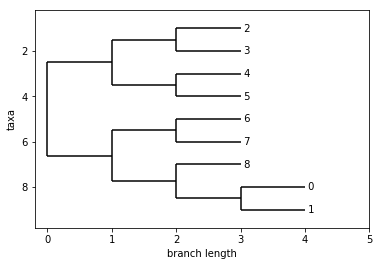

In [11]:
from Bio import Phylo as phy

'''
A lot of BioPython's functions only take file-like objects, 
StringIO just creates a memory buffer that lets a string pretend 
to be a file (technically a string buffer)
'''
from io import StringIO

# create string buffer from Newick string
tree_str = StringIO(str(treedata))
# read tree into a Phylo tree object
tree = phy.read(tree_str, 'newick')

'''
Prints ASCII tree to standard output (probably the console unless 
your setup is weird). If you want it saved to a file either pipe 
the output to a file in terminal or use sys.out (look it up)
'''
phy.draw_ascii(tree, column_width=30)

# if you're too cool for ASCII art (or just born after 1995), Phylo can also draw trees in matplotlib
phy.draw(tree)

To add noise, we added random point mutations in a larger dataset.

In [12]:
seq2 = ['CAGCCGCACACAGATCCTGAG',
       'CAGCTGCACGCAGATCCTGAG',
       'CGGCTGCACGCAGATCCTGAG',
       'CAGCTGCACGTGGATCCTGAG',
       'CGGCTGCACGTCGATCCTGAG',
       'CGGCTGCACGTGGATCCTGAG',
       'CAGCTGCATGTGGACCCTGAG', 
       'CAGCTGCATGTGGACCCAGAG', 
       'CGGCTCCATGTGGACCCAGAT'
       'CAGCTGCACGCAGATTTCAAG',
       'CGGCTGCACGCAGATTTCGAG',
       'CAGCTGCACGTGGATTTCGAG',
       'CGGCTGCACGAGGATCCTGAG'
       'CAGCTGCACGCAGATCCTCAG',
       'CGCCTGCACGCAGATCCTGAG',
       'CAGCTGCACGTGGATCCTGAG',
       'CGCCTGCACGTGGATCCAGAG']

In [13]:
dist_mat2 = calc_dist_mat(seq2, DNA_sim)

In [14]:
for row in dist_mat:
    print(['%.1f' % i for i in row])
  
print("\nWhich is the closest sequence pair in the sequence data?")

print(njPair(dist_mat))
tree2, node_ord = njTree(dist_mat2)

['0.0', '0.2']
['0.2', '0.0']

Which is the closest sequence pair in the sequence data?
[0, 1]


In [15]:
treedata2 = tree2
print(treedata2)

(((14, (0, 1)), ((2, 3), (4, 5))), (((6, 7), (8, 9)), ((10, 11), (12, 13))))


             _____ 14
       _____|
      |     |      _____ 0
      |     |_____|
      |           |_____ 1
  ____|
 |    |            _____ 2
 |    |      _____|
 |    |     |     |_____ 3
 |    |_____|
 |          |      _____ 4
 |          |_____|
 |                |_____ 5
_|
 |                 _____ 6
 |           _____|
 |          |     |_____ 7
 |     _____|
 |    |     |      _____ 8
 |    |     |_____|
 |    |           |_____ 9
 |____|
      |            _____ 10
      |      _____|
      |     |     |_____ 11
      |_____|
            |      _____ 12
            |_____|
                  |_____ 13



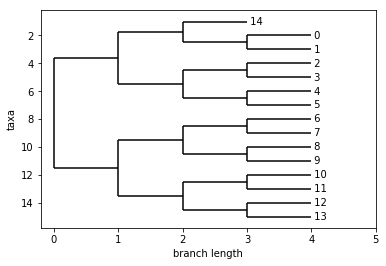

In [16]:
# create string buffer from Newick string
tree_str = StringIO(str(treedata2))
# read tree into a Phylo tree object
tree = phy.read(tree_str, 'newick')

'''
Prints ASCII tree to standard output (probably the console unless 
your setup is weird). If you want it saved to a file either pipe 
the output to a file in terminal or use sys.out (look it up)
'''
phy.draw_ascii(tree, column_width=30)

# if you're too cool for ASCII art (or just born after 1995), Phylo can also draw trees in matplotlib
phy.draw(tree)